# Tweety: Fake Detection

It is a natural language processing project prepared for the N.L.P. with Disaster Tweets competition on Kaggle for the purpose of building a machine learning model that predicts which tweets are about real disasters and which one’s aren’t.

The original notebook: https://www.kaggle.com/myasiny/tweety-fake-detection

In [1]:
import warnings
import pandas as pd

# Ignore warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# DATA

In [2]:
# Train and test sets

df_train = pd.read_csv('data/train.csv', index_col=False)
df_test = pd.read_csv('data/test.csv', index_col=False)

df_train.shape, df_test.shape

((7613, 5), (3263, 4))

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


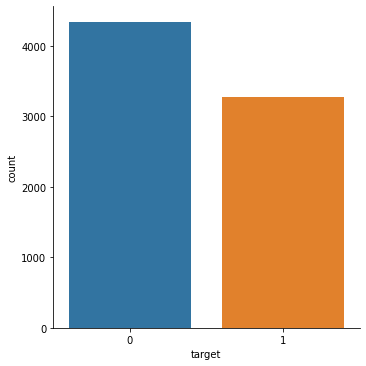

In [4]:
import seaborn as sns

# Distribution of targets

sns.catplot(data=df_train, x="target", kind="count");

### Pre-processing

In [12]:
import re
import emoji

def do_magic(some_text):
    # Remove emoji
    
    # some_text = emoji.get_emoji_regexp().sub(' ', some_text)
    
    # Replace emoji
    
    some_text = emoji.demojize(some_text, delimiters=('', ''))
    
    # Remove links
    
    some_text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', some_text)
    
    # Remove mentions
    
    some_text = re.sub('@[^\s]+', ' ', some_text)
    
    # Remove non-latin characters
    
    some_text = re.sub('[^\\x00-\\x7F\\x80-\\xFF\\u0100-\\u017F\\u0180-\\u024F\\u1E00-\\u1EFF]', ' ', some_text)
    
    # Remove non-word characters
    
    some_text = re.sub('\W', ' ', some_text)
    
    # Remove digits
    
    some_text = re.sub('\d+', ' ', some_text)
    
    # Remove stopwords
    
    some_text = ' '.join([i for i in some_text.split() if i not in set(open('data/stopwords', 'r').readlines())])
    
    # Remove multiple whitespaces
    
    some_text = re.sub(' +', ' ', some_text)
    
    return some_text.lower().strip()

In [13]:
df_train['magical_text'] = df_train.apply(lambda row: do_magic(row['text']), axis=1)

In [14]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def final_touch(magical_text):
    lemmatizer = WordNetLemmatizer()
    
    pos_tag = nltk.pos_tag(nltk.word_tokenize(magical_text))
    all_pos = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADV}
    
    # Apply lemmatization
    
    final_text = ' '.join([lemmatizer.lemmatize(word, all_pos.get(pos[0], wordnet.NOUN)) for word, pos in pos_tag])
    
    return final_text

In [19]:
df_train['final_text'] = df_train.apply(lambda row: final_touch(row['magical_text']), axis=1)

In [20]:
df_train[['text', 'magical_text', 'final_text']].head()

,text,magical_text,final_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,our deed be the reason of this earthquake may ...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,all resident ask to shelter in place be be not...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...,people receive wildfire evacuation order in ca...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,just get send this photo from ruby alaska a sm...


In [22]:
from sklearn.model_selection import train_test_split

# Split data into X and y

X, y = df_train['final_text'], df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
def fasttext_data(filename, X, y):
    with open(filename, 'w+') as f:
        for tweet in X:
            label = y[X[X == tweet].index[0]]
            f.write('__label__{} {}\n'.format(label, tweet))
    f.close()
    
# Reformat data for FastText

fasttext_data('data/train.txt', X_train, y_train)
fasttext_data('data/test.txt', X_test, y_test)

# MODEL

In [ ]:
# Download pre-trained vectors

# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

### Training

In [25]:
import fasttext

# Train model

model = fasttext.train_supervised(
    input='data/train.txt', 
    lr=1.0, 
    epoch=50, 
    wordNgrams=3, 
    dim=300 
    # pretrainedVectors='/kaggle/input/fasttext-pretrainedvectors-english-text/cc.en.300.vec'
)

In [26]:
# Number of samples, precision, recall

scores = model.test('data/test.txt')

scores

(1523, 0.788575180564675, 0.788575180564675)

# RESULT

In [27]:
def last_dance(model, tweet):
    # Use model to predict target label
    
    pred = model.predict(tweet)
    return pred[0][0].replace('__label__', '')

In [28]:
df_test['magical_text'] = df_test.apply(lambda row: do_magic(row['text']), axis=1)
df_test['final_text'] = df_test.apply(lambda row: final_touch(row['magical_text']), axis=1)
df_test['target'] = df_test.apply(lambda row: last_dance(model, row['final_text']), axis=1)

In [29]:
df_result = df_test[['id', 'target']]

df_result.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [30]:
df_result.to_csv('output/result.csv', index=False)

<AxesSubplot:xlabel='target'>

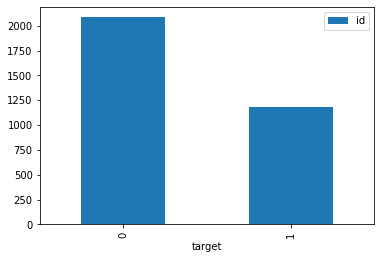

In [31]:
# Distribution of targets predicted

df_result.groupby(['target']).count().plot(kind='bar')

Kaggle score: 0.79